In [1]:
import os
import sys
sys.path.append("../data/neural_data/")
sys.path.append("../utils/")
sys.path.append("../fig1_1d2map/")
from pathlib import Path

import numpy as np
import itertools
import matplotlib.pyplot as plt

import basic_analysis as basic
import fig6_analysis as analysis
import analysis_neuro as spk
import fig6_plots

In [2]:
# file paths
data_folder = f"../data/neural_data/"
save_folder = f"../figures/fig6_plots/"
if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)
    
title_size = 10

save folder exists


In [3]:
# define the mouse, session, and example cell IDs
mice = ['Seattle', 'Toronto', 'Seattle', 'Toronto']
sessions = ['1010_1', '1111_1', '1006_1', '1117_1']
ex_cells = np.asarray([529, 521, 341, 252])
session_maps = np.asarray([3, 3, 4, 4])

session_IDs = []
for m, s in zip(mice, sessions):
    session_IDs.append(f'{m}_{s}')

In [4]:
''' load the data - single neuron and similarity '''
ex_idx = 0
session_ID = session_IDs[ex_idx]
c_id = ex_cells[ex_idx]
n_maps = session_maps[ex_idx]
d = analysis.load_neural_data(data_folder, session_ID)
print(f'loaded data for {session_ID}')

loaded data for Seattle_1010_1


In [5]:
''' divide by map and filter out unstable trials '''
d = analysis.format_neural_data(d, n_maps=n_maps,
                                filter_stability=True, unstable_thresh=0.25)

In [6]:
''' compute firing rates for each map '''
A = d['A']
B = d['B']

dt = 0.02 # time bin
pos_bin = 2 # cm
n_cells = B.shape[-1]
n_pos_bins = 400 // pos_bin

FRs = np.zeros([n_maps, n_pos_bins, n_cells])
FRs_sem = np.zeros([n_maps, n_pos_bins, n_cells])
for i in range(n_maps):
    m_idx = d['idx'][i, :]
    FRs[i], binned_pos, FRs_sem[i] = spk.tuning_curve(A[m_idx, 0],
                                             B[m_idx, :],
                                             dt, b=2, SEM=True)

In [7]:
''' save remap index for plotting '''
W = d['kmeans']['W']
trials = np.arange(0, W.shape[0]-1)

# define remaps
remap_idx = np.asarray([])
for i in range(n_maps):
    remaps = np.where(np.abs(np.diff(W[:, i])))[0]
    remap_idx = np.append(remap_idx, remaps)
remap_idx = np.unique(remap_idx)
remap_idx = remap_idx.astype(int)
d['remap_idx'] = remap_idx

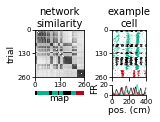

In [8]:
''' Figure 6A: 3 map examples for a single cell and the whole network '''
f, gs = fig6_plots.plot_b(d=d, cell_ID=c_id,
                          all_FR=FRs,
                          all_FR_sem=FRs_sem,
                          binned_pos=binned_pos)

f.savefig(f'{save_folder}{session_ID}_examples.png',
          dpi=600, bbox_inches='tight')
plt.show()

In [9]:
''' load the data - manifolds '''
ex_idx = 3
session_ID = session_IDs[ex_idx]
c_id = ex_cells[ex_idx]
n_maps = session_maps[ex_idx]
d = analysis.load_neural_data(data_folder, session_ID)
print(f'loaded data for {session_ID}')

loaded data for Toronto_1117_1


In [10]:
''' divide by map and filter out unstable trials '''
d = analysis.format_neural_data(d, n_maps=n_maps,
                                filter_stability=True, unstable_thresh=0.25)

In [11]:
# define the map pairs
m_ids = np.arange(n_maps)
m_pairs = list(itertools.combinations(m_ids,2))
for i, p in enumerate(m_pairs):
    m_pairs[i] = np.asarray(p)

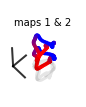

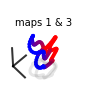

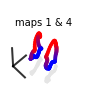

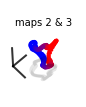

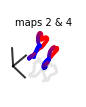

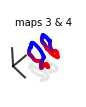

In [12]:
''' Figure 6B: example aligned manifolds for all pairs '''
# get the centers for each position bin
pos = d['A'][:, 0]
bin_size = 5
edges = np.arange(0, np.max(pos) + bin_size, bin_size)
binned_pos = (edges[:-1] + edges[1:])/2

# data params
Y = d['Y'].copy()
map_idx = d['idx']
W = d['kmeans']['W'].copy()
W_bool = W.astype(bool)

# plots
for m0_id, m1_id in m_pairs:
    map_idx = W_bool[:, m0_id] | W_bool[:, m1_id]
    f, ax = fig6_plots.plot_c(Y[map_idx], binned_pos)
    ax.set_title(f'maps {m0_id+1} & {m1_id+1}',
                 fontsize=title_size, pad=-2)
    plt.show()
    f.savefig(f'{save_folder}{session_ID}_manifolds_{m0_id+1}{m1_id+1}.png', 
              dpi=600, bbox_inches='tight')

mean misalignment = 0.69
sem misalignment = 0.055


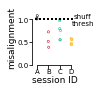

In [13]:
''' Figure 6C: summary of ring alignment '''
f, ax = fig6_plots.plot_d(data_folder, session_IDs, session_maps)
f.savefig(f'{save_folder}alignment_sort.png', dpi=600, bbox_inches='tight')
plt.show()

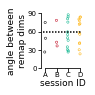

In [4]:
''' Possible Figure 6D: angle between remapping dimensions '''
f, ax = fig6_plots.plot_e(data_folder, session_IDs, session_maps)
f.savefig(f'{save_folder}remap_angles.png', dpi=600, bbox_inches='tight')
plt.show()

In [42]:
num_maps = session_maps
from dim_alignment import remapping_dim, cosine_sim

In [49]:
# data params
n_sessions = len(session_IDs)
n_maps = np.max(num_maps)
n_pairs = (np.math.factorial(n_maps)) // \
            (np.math.factorial(2)*np.math.factorial(n_maps-2))
dt = 0.02 # time bin
pos_bin = 2 # cm
n_pos_bins = 400 // pos_bin

all_angles = []
for i, s_id in enumerate(session_IDs):
    # define the map pairs
    n_maps = num_maps[i]
    m_ids = np.arange(n_maps)
    m_pairs = list(itertools.combinations(m_ids,2))

    # load + format the data
    d = analysis.load_neural_data(data_folder, s_id)
    d = analysis.format_neural_data(d, n_maps=n_maps)

    # compute firing rates for each map
    A = d['A']
    B = d['B']
    n_cells = B.shape[-1]
    map_idx = d['idx']
    FRs = np.zeros([n_maps, n_pos_bins, n_cells])
    for j in range(n_maps):
        m_idx = map_idx[j, :]
        FRs[j], _, _ = spk.tuning_curve(A[m_idx, 0],
                                        B[m_idx, :],
                                        dt, b=2, SEM=True)

    # find the remapping dimensions
    remap_dims = {}
    for m0_id, m1_id in m_pairs:
        remap_dims[f'[{m0_id} {m1_id}]'] = remapping_dim(FRs[m0_id], FRs[m1_id])

    # calculate the angles between all dimensions sharing a node
    all_pairs = list(itertools.combinations(np.asarray(m_pairs),2))
    adj_pairs = []
    for i, (j, k) in enumerate(all_pairs):
        m_diff = np.setdiff1d(j, k)
        if m_diff.shape[0] == 1:
            adj_pairs.append((str(j), str(k)))
    n_angles = len(adj_pairs)
    angles = np.zeros(n_angles)
    for j, (p0, p1) in enumerate(adj_pairs):
        angles[j] = cosine_sim(remap_dims[p0], \
                                remap_dims[p1])
    all_angles.append(angles)

In [51]:
all_angles_deg = []
for angles in all_angles:
    all_angles_deg.append(np.rad2deg(np.arccos(np.abs(angles))))

In [54]:
all_angles = all_angles_deg

3

In [63]:
# session colors
c1 = 'xkcd:scarlet'
c2 = 'xkcd:green blue'
c3 = 'k'
c4 = 'xkcd:saffron'
all_session_colors = [c2, c1, c3, c4]

# font sizes
title_size = 10
axis_label = 9
tick_label = 7

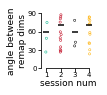

In [74]:
# data params
n_sessions = len(session_IDs)
n_maps = np.max(num_maps)
n_pairs = (np.math.factorial(n_maps)) // \
            (np.math.factorial(2)*np.math.factorial(n_maps-2))
dt = 0.02 # time bin
pos_bin = 2 # cm
n_pos_bins = 400 // pos_bin

# fig params 
f, ax = plt.subplots(1, 1, figsize=(1, 1))
DOT_LW = 0.5
DOT_SIZE = 5
THRESH_LW = 1.5
n_maps = np.max(num_maps)

# plot the angles b/w remap dims by session
for i in range(n_sessions):
    angles = all_angles[i]
    n_angles = angles.shape[0]
    JIT = np.random.randn(n_angles) * 0.03 # jitter points
    ax.scatter(np.full(n_angles, i+1)+JIT, angles, 
               facecolors='none', edgecolors=all_session_colors[i], 
               s=DOT_SIZE, lw=DOT_LW, alpha=1, zorder=0)

# plot the expected angles
ax.scatter(np.arange(n_sessions) + 1, 
           np.rad2deg(np.arccos(1/(num_maps-1))),
           marker='_',
           lw=THRESH_LW, color="k")

# ticks and lims
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds(0, 90)
ax.spines['bottom'].set_bounds(1, 4)
ax.set_xlim([0.6, 4.5])
ax.set_xticks([1, 2, 3, 4])
ax.set_ylim([0, 90])
ax.set_yticks(np.arange(0, 95, 30))
ax.tick_params(which='major', labelsize=tick_label, pad=0.5)

# labels
ax.set_ylabel('angle between\nremap dims', fontsize=axis_label, labelpad=1)
ax.set_xlabel('session num', fontsize=axis_label, labelpad=1)

f.savefig(f'{save_folder}remap_angles.png', dpi=600, bbox_inches='tight')
plt.show()

In [73]:
np.rad2deg(np.arccos(1/3))

70.52877936550931

In [ ]:
session_avg = int(np.mean(avg_angle))
session_sem = stats.sem(avg_angle)
print(f'angle between remapping dims (mean, sem) = {session_avg} deg., {session_sem:.2} deg.')

In [ ]:
'''
TODO:
X complete pairwise comparison for 4-map sessions (all pairs)
- angle between remapping dimensions
- transition probability matrix
- combine maps 2 & 3 for Toronto_1117_1?
X for misalignment plot:
    - combine all pairs?
    - color by mouse
'''

In [65]:
best = np.nanargmin(alignment_scores, axis=1)
adj_scores = alignment_scores.copy()
for i, s_id in enumerate(session_IDs):
    # define the map pairs
    n_maps = num_maps[i]
    m_ids = np.arange(n_maps)
    m_pairs = list(itertools.combinations(m_ids,2))

    # find the best pair
    b_pair = m_pairs[best[i]]

    # worst pair must contain one of the best maps
    j, k = b_pair
    idx = np.zeros(n_pairs)
    for o, p in enumerate(m_pairs):
        if (j in p) | (k in p):
            continue
        else:
            idx[o] = True
    adj_scores[i, idx.astype(bool)] = np.nan
worst = np.nanargmax(adj_scores, axis=1)

# redefine maps
# for i, s_id in enumerate(session_IDs):
i = 1
# define the map pairs
n_maps = num_maps[i]
m_ids = np.arange(n_maps)
m_pairs = list(itertools.combinations(m_ids,2))

# find the best and worst pairs
b_pair = np.asarray(m_pairs[best[i]])
w_pair = np.asarray(m_pairs[worst[i]])

# redefine the maps
new_m_ids = np.zeros(n_maps)
new_m_ids.fill(np.nan)
new_m_ids[0] = np.intersect1d(b_pair, w_pair)[0]
new_m_ids[1] = b_pair[b_pair != m_0][0]
new_m_ids[-1] = w_pair[w_pair != m_0][0]
if n_maps > 3:
    new_m_ids[2] = np.setdiff1d(m_ids, 
                                new_m_ids[~np.isnan(new_m_ids)].astype(int))[0]
new_m_ids.astype(int)

array([0, 1, 3, 2])

In [66]:
m_ids

array([0, 1, 2, 3])

In [64]:
new_m_ids = np.zeros(n_maps)
new_m_ids.fill(np.nan)
new_m_ids[0] = np.intersect1d(b_pair, w_pair)[0]
new_m_ids[1] = b_pair[b_pair != m_0][0]
new_m_ids[-1] = w_pair[w_pair != m_0][0]
if n_maps > 3:
    new_m_ids[2] = np.setdiff1d(m_ids, 
                                new_m_ids[~np.isnan(new_m_ids)].astype(int))[0]
new_m_ids.astype(int)

array([0., 1., 2., 3.])

In [63]:
np.setdiff1d(m_ids, new_m_ids[~np.isnan(new_m_ids)].astype(int))[0]

array([2])

In [28]:
print(f'best pair: ({j}, {k})')
print(m_pairs)
print(idx)

best pair: (0, 1)
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
[1. 1. 1. 1. 1. 0.]


In [17]:
best = np.nanargmin(alignment_scores, axis=1)
for i, s_id in enumerate(session_IDs):
    # define the map pairs
    n_maps = num_maps[i]
    m_ids = np.arange(n_maps)
    m_pairs = list(itertools.combinations(m_ids,2))
    
    b_pair = m_pairs[best[i]]
    w_pair = m_pairs[worst[i]]
    print(f'{s_id}: best pair is {m_pairs[b_idx]}, worst pair is {m_pairs[w_idx]}')

Seattle_1010_1: best pair is (0, 2), worst pair is (0, 1)
Seattle_1006_1: best pair is (0, 1), worst pair is (0, 2)
Toronto_1111_1: best pair is (0, 1), worst pair is (0, 2)
Toronto_1117_1: best pair is (0, 1), worst pair is (0, 3)


In [ ]:
# define 1:2 as most aligned, last:1 as least aligned
sort_alignment = np.sort(alignment_scores, axis=1)
flat_alignment = alignment_scores.ravel()
flat_alignment = flat_alignment[~np.isnan(flat_alignment)]